In [119]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
from scipy.signal import decimate
import matplotlib.pyplot as plt

3 Trace(s) in Stream:
AU.MANU.01.BHE | 2024-01-02T01:43:15.925000Z - 2024-01-03T02:43:15.900000Z | 40.0 Hz, 3600000 samples
AU.MANU.01.BHE | 2024-01-27T02:48:52.650000Z - 2024-01-27T03:15:26.975000Z | 40.0 Hz, 63774 samples
AU.MANU.01.BHE | 2024-02-21T11:17:24.150000Z - 2024-02-21T13:11:31.225000Z | 40.0 Hz, 273884 samples
Original sampling rate: 40.0 Hz
Mean amplitude: 1600.5388449124446


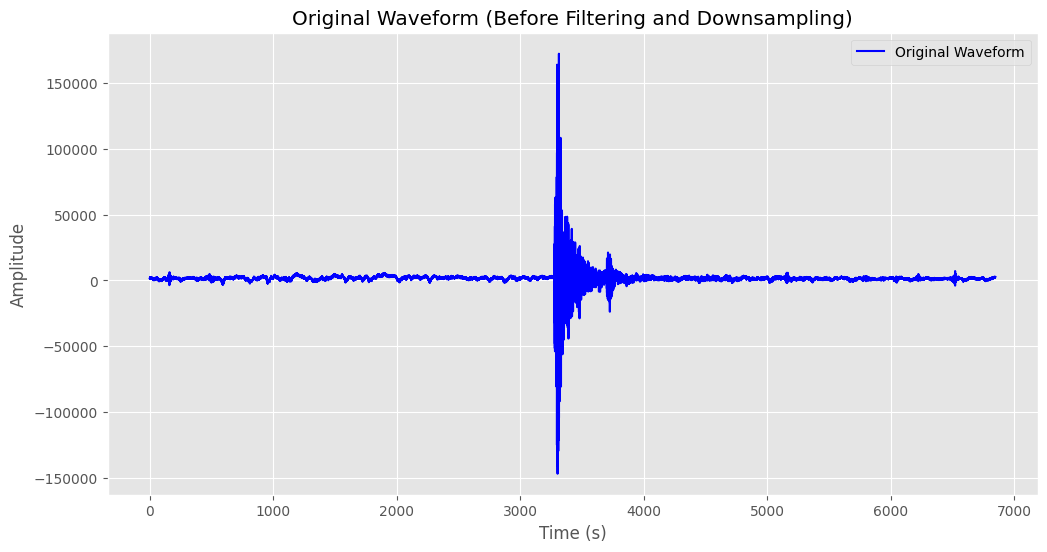

In [220]:
# Path to your .mseed file
mseed_file = "/mnt/c/Users/Utente/Desktop/3.mseed"

try:
    # Attempt to read the MiniSEED file
    st = read(mseed_file)
    print(st)

    # Get the first trace
    tr = st[2]

    # Print original sampling rate
    print(f"Original sampling rate: {tr.stats.sampling_rate} Hz")  
    mean_amplitude = np.mean(tr.data)
    print(f"Mean amplitude: {mean_amplitude}")
    # Plot the original waveform (before any processing)
    plt.figure(figsize=(12, 6))
    plt.plot(tr.times(), tr.data, label="Original Waveform",color="blue")
    plt.title("Original Waveform (Before Filtering and Downsampling)")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

except Exception as e:
    print(f"Error reading the file: {e}")


the aim of the code is to reduce the sampling rate of the seismic data to a lower target rate while preserving the integrity of the signal.
the downsample is mainly perfomed in order to have a better focus on the low frequency information.
this is done in 2 main step :
1. low pass filtering: When downsampling a signal, if we directly reduce the sampling rate without any precautions, we can introduce aliasing. Aliasing occurs when high-frequency components in the signal (those above half the new sampling rate, also known as the Nyquist frequency) fold back into lower frequencies, distorting the signal and making it unrecognizable.To prevent aliasing, we apply a low-pass filter before the downsampling step. The low-pass filter works by removing frequencies that are above the Nyquist frequency of the new target sampling rate. This ensures that after downsampling, there are no high-frequency components that could cause aliasing.
in the code the nyquist frequency is equal to 1 Hz (2/2) (tr.filter("lowpass", freq=target_sampling_rate / 2.0))
2. Decimation:  This step involves taking every nth sample from the signal and discarding the rest. Essentially, you reduce the number of samples by a fixed factor.

New sampling rate: 4.0 Hz
Original duration (approx): 68472.50 seconds
Downsampled duration: 6847.25 seconds


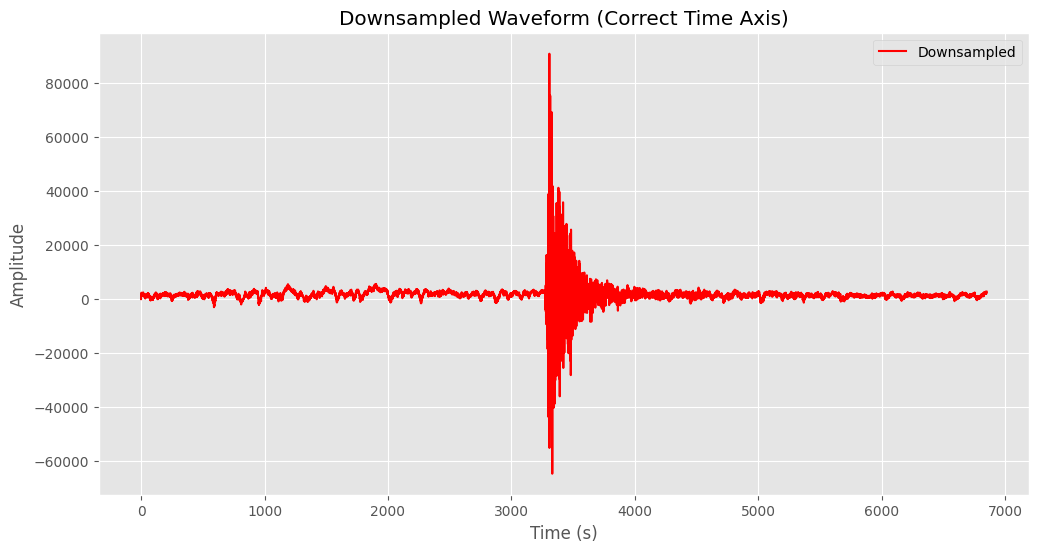

In [ ]:
target_sampling_rate = tr.stats.sampling_rate / 10

# Ensure the decimation factor is an integer (check if target is a divisor)
if tr.stats.sampling_rate % target_sampling_rate != 0:
    print(f"Warning: {target_sampling_rate} is not an exact divisor of {tr.stats.sampling_rate}.")
    # Adjust to the nearest valid target sampling rate
    target_sampling_rate = tr.stats.sampling_rate // 2
    print(f"Adjusted target sampling rate: {target_sampling_rate}")

# Step 1: Apply a low-pass filter to prevent aliasing (before downsampling)
#Nyquist frequency = half of the target sampling rate
tr.filter("lowpass", freq=target_sampling_rate / 2.0)

# Step 2: Downsample the signal using decimation
decimation_factor = int(tr.stats.sampling_rate / target_sampling_rate)
downsampled_data = decimate(tr.data, decimation_factor, ftype="iir")

# Step 3: Update metadata after downsampling
tr.stats.sampling_rate = target_sampling_rate
tr.stats.npts = len(downsampled_data)
tr.data = downsampled_data

# Step 4: Correct the time axis
# Generate a new time array based on the downsampled signal
downsampled_times = np.linspace(0, len(downsampled_data) / target_sampling_rate, len(downsampled_data))

# Print new sampling rate and check durations
print(f"New sampling rate: {tr.stats.sampling_rate} Hz")
original_duration = len(tr.data) / tr.stats.sampling_rate * decimation_factor
downsampled_duration = len(downsampled_data) / target_sampling_rate
print(f"Original duration (approx): {original_duration:.2f} seconds")
print(f"Downsampled duration: {downsampled_duration:.2f} seconds")

# Plot the downsampled waveform
plt.figure(figsize=(12, 6))
plt.plot(downsampled_times, downsampled_data, label="Downsampled", color="red")
plt.title("Downsampled Waveform (Correct Time Axis)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show() 


Original sampling rate: 40.0 Hz


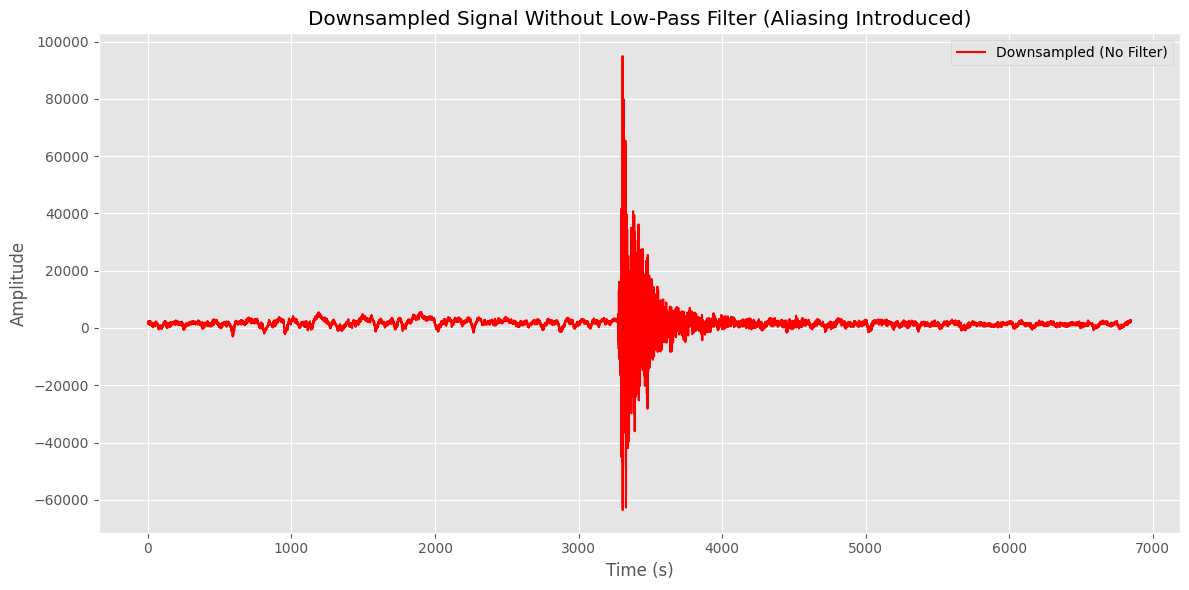

In [222]:
from obspy import read
from scipy.signal import decimate
import numpy as np
import matplotlib.pyplot as plt

# Load the seismic data
mseed_file = "/mnt/c/Users/Utente/Desktop/3.mseed"  
st = read(mseed_file)
tr = st[2]

# Original sampling rate
original_sampling_rate = tr.stats.sampling_rate
print(f"Original sampling rate: {original_sampling_rate} Hz")

# Define target sampling rate
target_sampling_rate = original_sampling_rate / 10
decimation_factor = int(original_sampling_rate / target_sampling_rate)

# Downsample without filtering (unsafe)
downsampled_data_no_filter = decimate(tr.data, decimation_factor)

# Generate time axes for plotting
original_times = np.linspace(0, len(tr.data) / original_sampling_rate, len(tr.data))
downsampled_times = np.linspace(0, len(downsampled_data_no_filter) / target_sampling_rate, len(downsampled_data_no_filter))

# Plot the original signal and the downsampled signal without filtering
plt.figure(figsize=(12, 6))
plt.plot(downsampled_times, downsampled_data_no_filter, label="Downsampled (No Filter)", color="red")
plt.title("Downsampled Signal Without Low-Pass Filter (Aliasing Introduced)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# Adjust layout and show plots
plt.tight_layout()
plt.show()
